In [1]:
import torch
import torchvision
from torch import nn

import torch.optim as optim
from torch.cuda.amp import GradScaler
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder
from torchvision.models.segmentation import fcn_resnet50, deeplabv3_mobilenet_v3_large

In [2]:

import torch
import torchvision.transforms.functional
from torch import nn

# SOURCE: https://nn.labml.ai/unet/index.html

class DoubleConvolution(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()

        # First 3x3 convolutional layer
        self.first = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.act1 = nn.ReLU()
        # Second 3x3 convolutional layer
        self.second = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()

    def forward(self, x: torch.Tensor):
        # Apply the two convolution layers and activations
        x = self.first(x)
        x = self.act1(x)
        x = self.second(x)
        return self.act2(x)


class DownSample(nn.Module):
    def __init__(self):
        super().__init__()
        # Max pooling layer
        self.pool = nn.MaxPool2d(2)

    def forward(self, x: torch.Tensor):
        return self.pool(x)


class UpSample(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()

        # Up-convolution
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    def forward(self, x: torch.Tensor):
        return self.up(x)


class CropAndConcat(nn.Module):
    def forward(self, x: torch.Tensor, contracting_x: torch.Tensor):
        contracting_x = torchvision.transforms.functional.center_crop(contracting_x, [x.shape[2], x.shape[3]])
        x = torch.cat([x, contracting_x], dim=1)
        return x


class UNet(nn.Module):
    def __init__(self, out_channels: int):
        super().__init__()

        down_conv_sizes = [(3, 64), (64, 128), (128, 256), (256, 512)]
        upsample_sizes = [(1024, 512), (512, 256), (256, 128), (128, 64)]
        up_conv_sizes = [(1024, 512), (512, 256), (256, 128), (128, 64)]

        self.down_conv = nn.ModuleList([DoubleConvolution(i, o) for i, o in down_conv_sizes])
        self.up_sample = nn.ModuleList([UpSample(i, o) for i, o in upsample_sizes])
        self.up_conv = nn.ModuleList([DoubleConvolution(i, o) for i, o in up_conv_sizes])

        self.down_sample = nn.ModuleList([DownSample() for _ in range(4)])
        self.concat = nn.ModuleList([CropAndConcat() for _ in range(4)])
        self.middle_conv = DoubleConvolution(512, 1024)

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x: torch.Tensor):
        # To collect the outputs of contracting path for later concatenation with the expansive path.
        pass_through = []

        # Contracting path
        for i in range(len(self.down_conv)):
            x = self.down_conv[i](x)
            pass_through.append(x)
            x = self.down_sample[i](x)

        x = self.middle_conv(x)

        # Expansive path
        for i in range(len(self.up_conv)):
            x = self.up_sample[i](x)
            x = self.concat[i](x, pass_through.pop())
            x = self.up_conv[i](x)

        x = self.final_conv(x)

        return x

In [3]:
# Define input size and number of classes
input_channels = 3
num_classes = 2

# Initialize U-Net model
model = UNet(out_channels=1)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from PIL import Image
import os


class SegmentationDataset(Dataset):
    def __init__(self, data_dir, image_transform=None, mask_transform=None):
        self.data_dir = data_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform

        self.image_files = sorted(os.listdir(os.path.join(data_dir, 'Images')))
        self.mask_files = sorted(os.listdir(os.path.join(data_dir, 'Masks')))

        assert len(self.image_files) == len(
            self.mask_files), "Number of images and masks don't match"

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.data_dir, 'Images', self.image_files[idx])
        mask_path = os.path.join(self.data_dir, 'Masks', self.mask_files[idx])

        image = Image.open(image_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')

        if self.image_transform:
            image = self.image_transform(image)

        if self.mask_transform:
            mask = self.mask_transform(mask)
        return image, mask

In [9]:

# Define data transforms
shared_transforms = [
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
]

image_transform = transforms.Compose([
    *shared_transforms,
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

mask_transform = transforms.Compose([
    *shared_transforms,
])

# Load the datasets
image_dataset = SegmentationDataset(
    'segmentation-data', image_transform=image_transform, mask_transform=mask_transform)

# Create data loaders
batch_size = 4
image_loader = DataLoader(image_dataset, batch_size=batch_size, shuffle=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Train the model
num_epochs = 1
model.to(device)

# Create a GradScaler object for gradient scaling
scaler = GradScaler()

for epoch in range(num_epochs):
    running_loss = 0
    for i, (images, masks) in enumerate(image_loader):

        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        running_loss += loss.item()
        if i % 10 == 9:
            print(
                f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(image_loader)}], Loss: {running_loss/10:.4f}')
            running_loss = 0.0

print('Training finished')

Epoch [1/1], Step [10/783], Loss: 0.0000
Epoch [1/1], Step [20/783], Loss: 0.0000
Epoch [1/1], Step [30/783], Loss: 0.0000
Epoch [1/1], Step [40/783], Loss: 0.0000
Epoch [1/1], Step [50/783], Loss: 0.0000
Epoch [1/1], Step [60/783], Loss: 0.0000
Epoch [1/1], Step [70/783], Loss: 0.0000
Epoch [1/1], Step [80/783], Loss: 0.0000
Epoch [1/1], Step [90/783], Loss: 0.0000
Epoch [1/1], Step [100/783], Loss: 0.0000
Epoch [1/1], Step [110/783], Loss: 0.0000
Epoch [1/1], Step [120/783], Loss: 0.0000
Epoch [1/1], Step [130/783], Loss: 0.0000
Epoch [1/1], Step [140/783], Loss: 0.0000
Epoch [1/1], Step [150/783], Loss: 0.0000
Epoch [1/1], Step [160/783], Loss: 0.0000
Epoch [1/1], Step [170/783], Loss: 0.0000
Epoch [1/1], Step [180/783], Loss: 0.0000
Epoch [1/1], Step [190/783], Loss: 0.0000
Epoch [1/1], Step [200/783], Loss: 0.0000
Epoch [1/1], Step [210/783], Loss: 0.0000
Epoch [1/1], Step [220/783], Loss: 0.0000
Epoch [1/1], Step [230/783], Loss: 0.0000
Epoch [1/1], Step [240/783], Loss: 0.0000
E

In [7]:

# Save the trained model
torch.save(model.state_dict(), 'test_model.pth')

In [13]:
model = UNet(out_channels=1)
model.load_state_dict(torch.load('test_model.pth'))
model.to(device)

UNet(
  (down_conv): ModuleList(
    (0): DoubleConvolution(
      (first): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act1): ReLU()
      (second): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act2): ReLU()
    )
    (1): DoubleConvolution(
      (first): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act1): ReLU()
      (second): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act2): ReLU()
    )
    (2): DoubleConvolution(
      (first): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act1): ReLU()
      (second): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act2): ReLU()
    )
    (3): DoubleConvolution(
      (first): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act1): ReLU()
      (second): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act2): ReLU()
    )
 

In [14]:
ims = []
for i in range(4):
    ims.append(image_dataset[i][0])

images = torch.stack(ims)

In [ ]:
output = model(images.to(device))

In [39]:
msks = output.cpu().detach()
imgs = images.cpu().detach()

msks = msks.permute(0, 2, 3, 1)

In [40]:
msks = list(msks)
imgs = list(imgs)

In [47]:
reverse_transform = transforms.Compose([
    transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], std=[1/0.229, 1/0.224, 1/0.225]),
    lambda x: x.numpy().transpose((1, 2, 0))  # Convert tensor back to numpy array and transpose dimensions
])

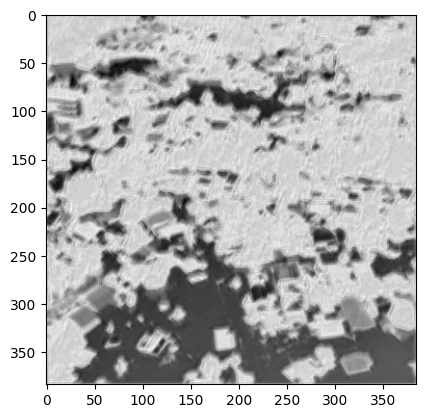

RuntimeError: The size of tensor a (384) must match the size of tensor b (3) at non-singleton dimension 0

In [48]:

import matplotlib.pyplot as plt
plt.imshow(msks[0], cmap='gray')
plt.show()
plt.imshow(reverse_transform(imgs[0]))

In [ ]:
output = model(images.to(device))

msks = mask_transform(output.cpu().detach())
imgs = images.cpu().detach()

import matplotlib.pyplot as plt
plt.imshow(imgs[0].permute(1, 2, 0))
plt.show()
plt.imshow(imgs[0].reshape(384, 384))